# Rappler Article Transfer Learning
- The goal is to create an accurate classifier that would utilize only the subheader and title of the article.


Let's first import our dependencies.

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Let's utilize the CPU for training.

In [2]:
device = torch.device("cpu")

Load the dataset for data cleaning and wrangling.

In [3]:
df = pd.read_excel("~/Downloads/rappler.xlsx")
df = df.fillna('', inplace=False)
df['Content'] = df['Article Name'] + ' ' + df['Subheader']

Create the test set for use in evaluation later on. Also remove the test set from the original dataset that will then be divided to train and validation later.

In [4]:
test = df[df['Category']=='Technology'][:100]
test = test.append(df[df['Category']=='Crime'][:100])
test = test.append(df[df['Category']=='SportLoad the dataset for data cleaning and wrangling.s'][:100])
test = test.append(df[df['Category']=='Business'][:100])
print(df.shape)
df = df[~df.isin(test)].dropna()
print(df.shape)

(8095, 4)
(7695, 4)


Turn the categories into integers for training our model.

In [5]:
df['Category'] = df['Category'].astype('category')
df['Category'] = df['Category'].cat.codes
df.head()
# 0 BUSINESS, 1 CRIME, 2 SPORTS, 3 TECHNOLOGY

,Article Name,Subheader,Category,Content
100,Warriors named Sports Illustrated's 'Sportsper...,The Golden State is the first NBA team to rece...,2,Warriors named Sports Illustrated's 'Sportsper...
101,PH Sports Training Center to rise in Pangasina...,The new Philippine Sports Training Center Act ...,2,PH Sports Training Center to rise in Pangasina...
102,PH begins countdown to hosting SEA Games 2019,The Philippines has less than 365 days to go u...,2,PH begins countdown to hosting SEA Games 2019 ...
103,LOOK: SEA Games 2019 logo stands tall at Bayan...,The Philippine SEA Games Organizing Committee ...,2,LOOK: SEA Games 2019 logo stands tall at Bayan...
104,"SEA GAMES 2019: Skateboarding, windsurfing amo...",The Southeast Asian Games Federation Council a...,2,"SEA GAMES 2019: Skateboarding, windsurfing amo..."


Create our sentences by retrieving the contents of all entries in our dataset. Add the special tokens as well as BERT requires those to be present. We need to retrieve the labels as well as it will be used to supervise our model later on.

In [6]:
# Create sentence and label lists
sentences = df.Content.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.Category.values

Tokenize our dataset. We'll be using bert-base-uncased as our tokenizer which means that we'll be making sure that each letter is lower case.

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'warriors', 'named', 'sports', 'illustrated', "'", 's', "'", 'sports', '##person', 'of', 'the', 'year', "'", 'the', 'golden', 'state', 'is', 'the', 'first', 'nba', 'team', 'to', 'receive', 'the', 'award', 'for', 'their', 'collective', 'feat', '##s', 'on', 'the', 'court', 'over', 'the', 'past', '5', 'years', '[SEP]']


Set the maximum length of each entry in our dataset. This allows us to have uniform lengths for each entry.

In [8]:
MAX_LEN = 128

Tokenize our text data.

In [9]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Pad our inputs so we'll have uniform size for each sentence in our dataset.

In [10]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create an attention mask to know when there are real words or when there's padding instead.

In [11]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

Split our dataset into train and validation.

In [12]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

Let's make our data compatible with our model by converting it to the proper datatype.

In [13]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs, dtype=torch.long)
validation_inputs = torch.tensor(validation_inputs, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

Create our DataLoaders for our training loop later. This will allow us to iterate through the dataset by batches.

In [14]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


Load in our pretrained BERT model. Modifying num_labels would change the number of outputs the last layer would yield out.

In [15]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

For our optimizer we'll be choosing BertAdam. The difference between BertAdam and Adam are the following:
- BertAdam implements weight decay fix,
- BertAdam doesn't compensate for bias as in the regular Adam optimizer.

In [16]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

For our optimizer we'll be choosing BertAdam. The difference between BertAdam and Adam are the following:
- BertAdam implements weight decay fix,
- BertAdam doesn't compensate for bias as in the regular Adam optimizer.

In [17]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


Create the flat_accuracy function to convert our model outputs from scores to its predicted labels then calculate the accuracy by comparing it with the true labels. Let's add in the training loop as well. 

In [18]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Training
  
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
#     print("train")
    for step, batch in enumerate(train_dataloader):
#         print(str(step+1) + '/' + '217 : ' + 'Epoch : ' + str(_ + 1))
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1


    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    
    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
#     print("evaluation")
    for step, batch in enumerate(validation_dataloader):
#         print(str(step+1) + '/' + '25 : ' + 'Epoch : ' + str(_ + 1))
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

torch.save(model.state_dict(), 'model.pt')

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4426473255187685


Epoch:  25%|██▌       | 1/4 [1:05:23<3:16:09, 3923.27s/it]

Validation Accuracy: 0.88
Train loss: 0.21176936865402257


Epoch:  50%|█████     | 2/4 [2:10:41<2:10:43, 3921.84s/it]

Validation Accuracy: 0.89125
Train loss: 0.13305053268537817


Epoch:  75%|███████▌  | 3/4 [3:16:15<1:05:25, 3925.43s/it]

Validation Accuracy: 0.88625
Train loss: 0.09248138675552016


Epoch: 100%|██████████| 4/4 [4:21:54<00:00, 3928.58s/it]  

Validation Accuracy: 0.895


Check the result of our training by plotting the training loss.

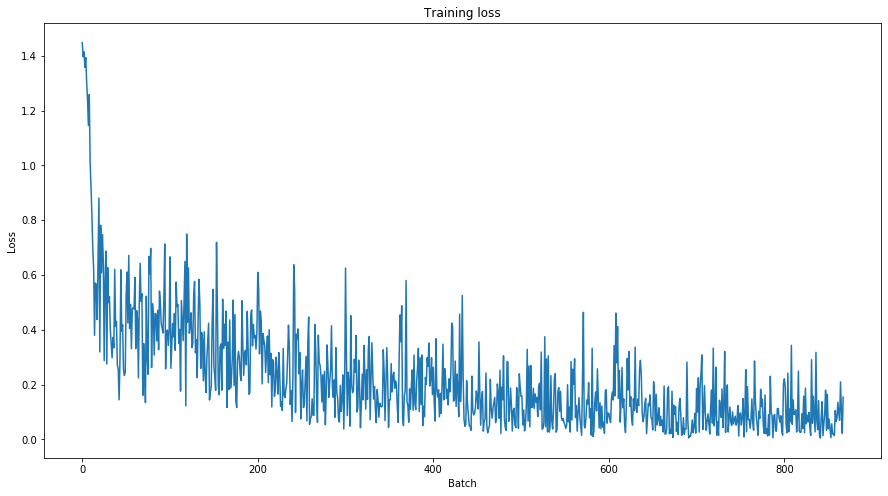

In [19]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Let's now evaluate our model on data that it has never seen before. Apply the same pre-processing step for our test data.

In [20]:
test['Category'] = test['Category'].astype('category')
test['Category'] = test['Category'].cat.codes
# Create sentence and label lists
sentences = test.Content.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = testCheck the true_labels array to see the "correct" labels of each input..Category.values

Pre-process our test data and tokenize the text. Load our test dataset to a DataLoader so that we can iterate by batch for our evaluation loop.

In [21]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids, dtype=torch.long)
prediction_masks = torch.tensor(attention_masks, dtype=torch.long)
prediction_labels = torch.tensor(labels, dtype=torch.long)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Feed the test data to the model.

In [22]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
for step, batch in enumerate(prediction_dataloader):
    print("Batch num: " + str(step+1))
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)


Batch num: 1
Batch num: 2
Batch num: 3
Batch num: 4
Batch num: 5
Batch num: 6
Batch num: 7
Batch num: 8
Batch num: 9
Batch num: 10
Batch num: 11
Batch num: 12
Batch num: 13


Check the output of the model. (We still need to use argmax for it to choose the label with the highest score)

In [23]:
predictions

[array([[-1.9586426e+00, -2.8379362e+00, -1.0753717e+00,  5.0994287e+00],
        [-1.7548183e+00, -2.8589425e+00, -1.4181907e+00,  5.3687181e+00],
        [-1.8078938e+00, -2.8976665e+00, -1.3530729e+00,  5.3934841e+00],
        [-1.8222904e+00, -2.9892435e+00, -1.1579009e+00,  5.2481389e+00],
        [-1.8439908e+00, -2.4888144e+00, -1.7104659e+00,  5.3223720e+00],
        [ 1.1331377e+00, -3.3681760e+00, -2.9067638e+00,  4.0798621e+00],
        [-2.0960412e+00, -1.6579634e+00, -1.8988057e+00,  5.1960158e+00],
        [-1.3473339e+00, -2.8525472e+00, -1.8918185e+00,  5.3781881e+00],
        [-2.0457518e+00,  6.8972409e-01, -2.2260437e+00,  3.1899357e+00],
        [-1.2802944e+00, -3.2775493e+00, -1.5518001e+00,  5.3272777e+00],
        [ 4.1301422e+00, -3.7588973e+00, -2.1411061e+00,  1.3385808e+00],
        [-1.5347923e+00, -2.9879894e+00, -1.5694840e+00,  5.4381032e+00],
        [-2.3563266e+00, -2.1533961e+00, -1.0970583e+00,  4.6661696e+00],
        [-2.0108852e+00, -2.0917988e+0

Check the true_labels array to see the "correct" labels of each input.

In [24]:
true_labels

[array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 

Create the lists that will be fed into the classification_report function that will create a confusion matrix. We use np.argmax to choose the category with the highest score as its prediction.

In [25]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

Display the confusion matrix so we can evaluate how well our model classifies with data that it has never seen before.

In [26]:
import numpy as np
from sklearn.metrics import classification_report

print(classification_report(flat_true_labels,
                            flat_predictions,
                            target_names = [
                                'Business',
                                'Crime',
                                'Sports',
                                'Technology']))

              precision    recall  f1-score   support

    Business       0.92      0.78      0.84       100
       Crime       0.92      0.97      0.95       100
      Sports       0.94      0.97      0.96       100
  Technology       0.85      0.91      0.88       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



The results above are very promising. How about we try the model out on our own "Article" to see if it can classify it properly. Let's first implement a predictor function that will process our text so that it can be fed into the model.

In [72]:
# Create function for predicting
def predictor(sentence):
    # We need to add special tokens at the beginning and end of each sentence for BERT to work properly
    sentence = "[CLS] " + sentence + " [SEP]"
    label = 0

    tokenized_text = tokenizer.tokenize(sentence)

    MAX_LEN = 128
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_id = [tokenizer.convert_tokens_to_ids(tokenized_text)]
    # Pad our input tokens
    input_id = pad_sequences(input_id, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    prediction_input = torch.tensor(input_id, dtype=torch.long)
    logits = model(prediction_input)
    flat_predictions = np.argmax(logits.detach().cpu().numpy(), axis=1).flatten()

    print("Prediction:")
    if flat_predictions[0] == 0:
        print('Business')
    elif flat_predictions[0] == 1:
        print('Crime')
    elif flat_predictions[0] == 2:
        print('Sports')
    elif flat_predictions[0] == 3:
        print('Technology')

Let's test our model with the predictor function to check how it classifies.

In [96]:
sentence = 'Gillas steals the cup from Ateneo.'
predictor(sentence)

Prediction:
Sports
